In [31]:
import matplotlib.pyplot as plt

def draw_gt_pred_slices(pred, gt, slice_indices=None, organ_name=""):
    """
    Display slices with ground truth and predicted labels side-by-side.

    Parameters:
    - gt: ground truth mask (slices, H, W)
    - pred: predicted mask (slices, H, W)
    - slice_indices: list of slice indices to visualize
    - organ_name: name to label the plots
    """

    num_slices = gt.shape[0]

    # If no slices are specified, choose 3 evenly spaced slices
    if slice_indices is None:
        slice_indices = np.linspace(0, num_slices - 1, num=3, dtype=int)

    for idx in slice_indices:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[1].imshow(pred[idx], cmap='gray')
        axs[1].set_title(f"raw ({organ_name}) - Slice {idx}")
        axs[1].axis('off')
        axs[0].set_title(f"GT+raw ({organ_name}) - Slice {idx}")
        
        axs[0].imshow(pred[idx], cmap='gray')  # Display the raw image
        axs[0].imshow(gt[idx], cmap='jet', alpha=0.5)  # Overlay the GT with some transparency
        axs[0].axis('off')

        plt.tight_layout()
        plt.draw()
        plt.show()


(987, 512, 512) (987, 512, 512)


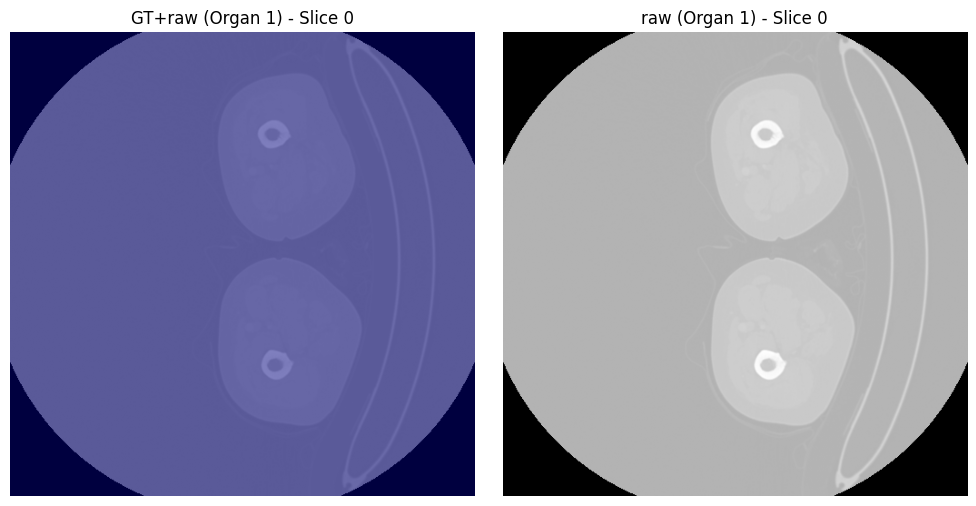

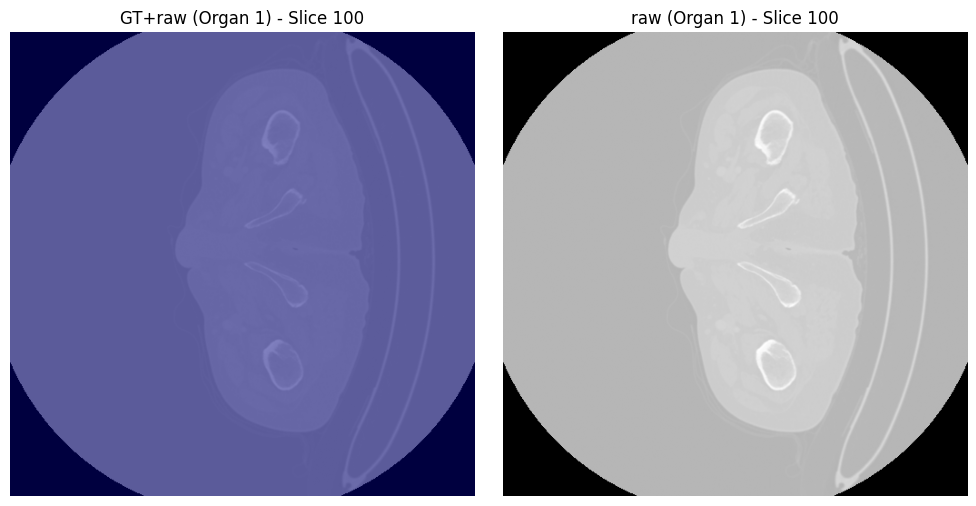

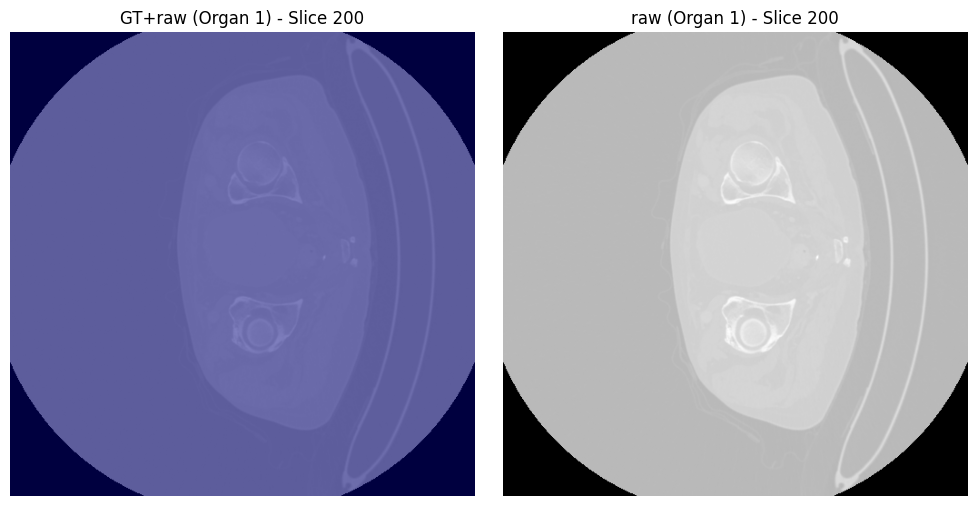

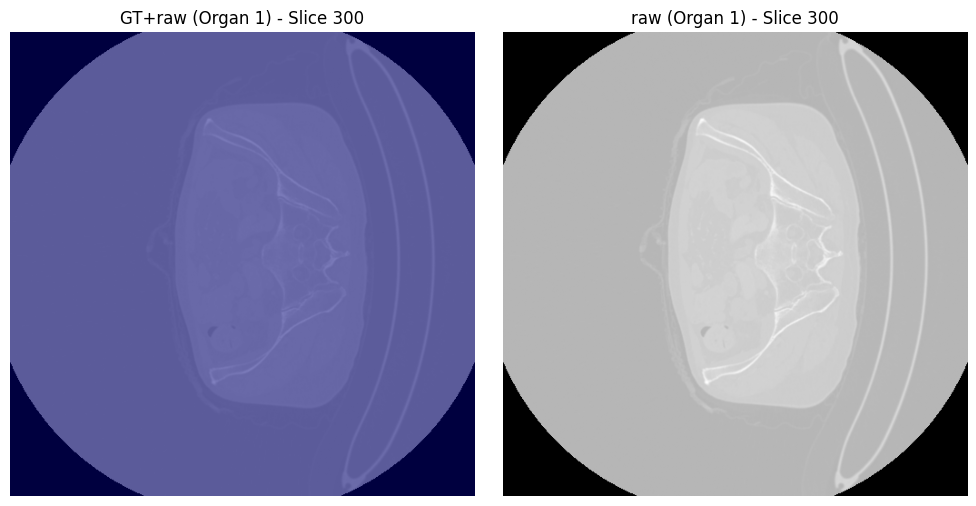

In [32]:

import nibabel as nib
import numpy as np
# 1. Load the raw image (not used in this function but you can use it for context if needed)
raw_image = nib.load('truc/feur/UKCHLL061/image.nii.gz').get_fdata()
raw_image = raw_image.transpose(2,0,1)

# 2. Load the predicted segmentation
pred_segmentation = nib.load('truc/feur/testing.nii.gz').get_fdata()
pred_segmentation = pred_segmentation.transpose(2,0,1)

# 3. Load the probabilities (3 classes)
probas = np.load('truc/feur/testing.npz')

# Assuming the probability array is (slices, H, W, num_classes)
# Extract the class probabilities (e.g., for each voxel, select the class with the highest probability)
pred_class = np.argmax(probas['probabilities'], axis=0)  # Shape: (slices, H, W)

# 4. Load the ground truth annotations (three different annotations)
gt_1 = nib.load('truc/feur/UKCHLL061/annotation_1.nii.gz').get_fdata()
gt_1 = gt_1.transpose(2,0,1)
gt_2 = nib.load('truc/feur/UKCHLL061/annotation_2.nii.gz').get_fdata()
gt_2 = gt_2.transpose(2,0,1)
gt_3 = nib.load('truc/feur/UKCHLL061/annotation_3.nii.gz').get_fdata()
gt_3 = gt_3.transpose(2,0,1)

print(raw_image.shape, gt_1.shape)
# Stack the GT annotations into one array (if you want to visualize them together)
gt = np.stack([gt_1, gt_2, gt_3], axis=0)  # Shape: (3, slices, H, W)

# 5. Draw the slices (for example, visualize slices 0, 10, and 20)
slice_indices = [0, 100, 200, 300]

# Visualize for each organ (or specific ground truth annotation)
draw_gt_pred_slices(raw_image, gt_2, slice_indices=slice_indices, organ_name="Organ 1")
#draw_gt_pred_slices(gt[0], pred_class, slice_indices=slice_indices, organ_name="Organ 1")
#draw_gt_pred_slices(gt[1], pred_class, slice_indices=slice_indices, organ_name="Organ 2")
#draw_gt_pred_slices(gt[2], pred_class, slice_indices=slice_indices, organ_name="Organ 3")

In [ ]:
#UNC MAP (mais très emmêlé) --> utile ?
def get_gt_unc_map(self, image_id):
        if self.exp_version.gt_unc_map_loading is None:
            n_reference_segs = self.exp_version.n_reference_segs
            reference_segs_paths = [
                self.ref_seg_dir / f"{image_id}_{i:02d}{self.exp_version.image_ending}"
                for i in range(n_reference_segs)
            ]
            reference_segs = []
            for reference_seg_path in reference_segs_paths:
                reference_seg, _ = load(reference_seg_path)
                reference_segs.append(reference_seg)
            reference_segs = np.array(reference_segs)
            per_pixel_variance = np.var(reference_segs, axis=0)
        else:
            per_pixel_variance = hydra.utils.instantiate(
                self.exp_version.gt_unc_map_loading,
                image_id=image_id,
                dataloader=self.dataloader,
            )
        return per_pixel_variance